# Gold Price Prediction Using Machine Learning

This project analyzes and predicts daily gold prices using multiple machine learning regression models combined with economic indicators.


## Imports

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pandas_datareader.data import DataReader
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

# Date range
start_date = '2024-11-30'
end_date = '2025-11-30'


## Data Collection

### Gold Futures Data Extraction (2025)

- In this section, we download daily Gold Futures (GC=F) data for the date range January 1, 2025 to November 30, 2025 using the  `yfinance` library.
- then clean and format the dataset by resetting the index, removing unnecessary columns.
- Finally,export the processed dataset into a clean CSV file suitable for analysis or machine-learning tasks.

In [2]:
# Ticker for Gold Futures
ticker = "GC=F"

# Download daily data
data_gold = yf.download(ticker, start=start_date, end=end_date, interval="1d", auto_adjust=False)

# Reset index so Date becomes a column
data_gold.reset_index(inplace=True)

# Flatten columns if multi-level
if isinstance(data_gold.columns, pd.MultiIndex):
    data_gold.columns = [col[0] for col in data_gold.columns]

# Drop 'Adj Close' if present
data_gold = data_gold.drop(columns=['Adj Close'], errors='ignore')

# Format Date
data_gold['Date'] = data_gold['Date'].dt.strftime('%#m/%#d/%Y')

data_gold.rename(columns={'Close': 'Gold_Price'}, inplace=True)


# Save to CSV
data_gold.to_csv("Gold_futures_2025.csv", index=False)

print(f"Saved {len(data_gold)} rows to Gold_futures_2025.csv")


[*********************100%***********************]  1 of 1 completed

Saved 251 rows to Gold_futures_2025.csv


In [3]:
data_gold.head()

,Date,Gold_Price,High,Low,Open,Volume
0,12/2/2024,2634.899902,2649.800049,2621.699951,2649.000000,695
1,12/3/2024,2644.699951,2654.699951,2636.000000,2639.000000,1062
2,12/4/2024,2653.800049,2658.300049,2637.000000,2639.199951,249
3,12/5/2024,2626.600098,2655.000000,2625.699951,2652.399902,573
4,12/6/2024,2638.600098,2643.100098,2617.500000,2620.199951,571


In [4]:
data_gold.shape

(251, 6)

### Brent crude oil

- In this section, we download daily Brent crude oil futures (BZ=F) data from January 1, 2025 to November 30, 2025 using the `yfinance` library.
- then clean and format the dataset by resetting the index, removing unnecessary columns.
- Finally,export the processed dataset into a clean CSV file suitable for analysis or machine-learning tasks.

In [5]:
# Ticker for Brent crude oil
ticker = "BZ=F"

# Download data
data_oil = yf.download(
    ticker,
    start=start_date,
    end=end_date,
    interval="1d",
    auto_adjust=False
)

# Reset index
data_oil.reset_index(inplace=True)

# Flatten columns if multi-level
if isinstance(data_oil.columns, pd.MultiIndex):
    data_oil.columns = [col[0] for col in data_oil.columns]

# Keep only Date and Close
data_oil = data_oil[['Date', 'Close']]

# Rename Close to Price
data_oil = data_oil.rename(columns={'Close': 'Price'})

# Format Date
data_oil['Date'] = data_oil['Date'].dt.strftime('%#m/%#d/%Y')

# Round Price
data_oil['Price'] = data_oil['Price'].round(2)

# Save to CSV
data_oil.to_csv("Brent_crude_oil_2025.csv", index=False)


[*********************100%***********************]  1 of 1 completed


In [6]:
data_oil.head()

,Date,Price
0,12/2/2024,71.83
1,12/3/2024,73.62
2,12/4/2024,72.31
3,12/5/2024,72.09
4,12/6/2024,71.12


In [7]:
data_oil.shape

(251, 2)

### US Dollar Index (DXY)

- In this section, we download daily US Dollar Index (DXY) data from January 1, 2025 to November 30, 2025 using the `yfinance` library.
- Then, we clean and format the dataset by resetting the index and keeping only relevant columns.
- Finally, we export the processed dataset into a clean CSV file suitable for analysis or machine-learning tasks.

In [8]:
import yfinance as yf
import pandas as pd

# Ticker for US Dollar Index (DXY)
ticker = "DX-Y.NYB"

# Download data
data_dxy = yf.download(
    ticker,
    start=start_date,
    end=end_date,
    interval="1d",
    auto_adjust=False
)

# Reset index
data_dxy.reset_index(inplace=True)

# Flatten columns if multi-level
if isinstance(data_dxy.columns, pd.MultiIndex):
    data_dxy.columns = [col[0] for col in data_dxy.columns]

# Keep only Date and Close
data_dxy = data_dxy[['Date', 'Close']]

# Rename Close to Price
data_dxy = data_dxy.rename(columns={'Close': 'Price'})

# Format Date
data_dxy['Date'] = data_dxy['Date'].dt.strftime('%#m/%#d/%Y')

# Round Price
data_dxy['Price'] = data_dxy['Price'].round(2)

# Save to CSV
data_dxy.to_csv("DXY_2025.csv", index=False)

print("DXY data saved to DXY_2025.csv")


[*********************100%***********************]  1 of 1 completed

DXY data saved to DXY_2025.csv


In [9]:
# Show first rows
print(data_dxy.head())

        Date   Price
0  12/2/2024  106.45
1  12/3/2024  106.37
2  12/4/2024  106.34
3  12/5/2024  105.71
4  12/6/2024  105.97


In [10]:
data_dxy.shape

(251, 2)

### FRED Federal Funds Rate (FEDFUNDS)

- In this section, we download monthly Federal Funds Rate (FEDFUNDS) data from January 1, 2025 to November 30, 2025 using the `pandas_datareader` library from FRED.
- The Federal Funds Rate is the rate at which banks lend money to each other for a short period, and it is used by the Federal Reserve to manage the economy.
###Since FRED provides the data monthly, we convert it to daily data by forward-filling the monthly values for each day in the date range.

**Reasoning:**
- Gold prices fluctuate on a **daily basis**, and using monthly interest rates would smooth out important short-term variations.
- The daily EFFR provides **higher temporal resolution**, allowing the model to better capture short-term market reactions.
- Financial markets often respond immediately to interest rate changes, making daily rates more suitable for time-series prediction tasks.

As a result, using daily EFFR improves the alignment between the input features and the target variable (gold price).
- Then, we clean and format the dataset by resetting the index, keeping only the `Date` and `Price` columns, and rounding the values.
- Finally, we export the processed dataset into a clean CSV file suitable for analysis or machine-learning tasks.


In [11]:
# Date range (as datetime objects)
start_date = datetime.datetime(2024, 12, 1)
end_date = datetime.datetime(2025, 11, 30)

# Download FRED EFFR data (daily effective rate)
fredfund = DataReader('EFFR', 'fred', start_date, end_date)

# Create a daily date range
daily_index = pd.date_range(start=start_date, end=end_date, freq='D')

# Reindex to daily and forward-fill (for weekends/holidays)
fredfund_daily = fredfund.reindex(daily_index, method='ffill')

# Reset index
fredfund_daily.reset_index(inplace=True)

# Rename columns correctly: 'index' -> 'Date', 'EFFR' -> 'Price'
fredfund_daily = fredfund_daily.rename(columns={'index': 'Date', 'EFFR': 'Price'})

# Format Date
fredfund_daily['Date'] = fredfund_daily['Date'].dt.strftime('%#m/%#d/%Y')

# Round Price
fredfund_daily['Price'] = fredfund_daily['Price'].round(2)

# Save to CSV
fredfund_daily.to_csv("effr_2025_daily.csv", index=False)

print("Daily EFFR data saved to effr_2025_daily.csv")
print(fredfund_daily.tail())  # To check the last few rows

Daily EFFR data saved to effr_2025_daily.csv
           Date  Price
360  11/26/2025   3.88
361  11/27/2025    NaN
362  11/28/2025   3.89
363  11/29/2025   3.89
364  11/30/2025   3.89


In [12]:
print(fredfund_daily.head())

        Date  Price
0  12/1/2024    NaN
1  12/2/2024   4.58
2  12/3/2024   4.58
3  12/4/2024   4.58
4  12/5/2024   4.58


In [13]:
fredfund_daily.shape

(365, 2)

## Merging Data

- Load and rename CSVs for Gold, Brent, DXY, and FEDFUNDS.  
- Merge on `Date` and save as `merged_gold_market_data_2025.csv`.

In [14]:
import pandas as pd

# Load CSVs with date parsing
gold = pd.read_csv("Gold_futures_2025.csv", parse_dates=['Date'])
brent = pd.read_csv("Brent_crude_oil_2025.csv", parse_dates=['Date'])
dxy = pd.read_csv("DXY_2025.csv", parse_dates=['Date'])
fedfund = pd.read_csv("effr_2025_daily.csv", parse_dates=['Date'])  # or fredfund_2025_daily.csv

# Rename columns
brent = brent.rename(columns={'Price': 'Brent_Price'})
dxy = dxy.rename(columns={'Price': 'DXY_Price'})
fedfund = fedfund.rename(columns={'Price': 'Fed_Rate'})  # I recommend 'Fed_Rate' or 'EFFR' for clarity

# Merge on Gold dates only (left join)
df = gold.merge(brent[['Date', 'Brent_Price']], on='Date', how='left') \
         .merge(dxy[['Date', 'DXY_Price']], on='Date', how='left') \
         .merge(fedfund[['Date', 'Fed_Rate']], on='Date', how='left')

# Final check
print(f"Merged dataset: {df.shape[0]} rows × {df.shape[1]} columns")

# Save
df.to_csv("merged_gold_market_data_2025.csv", index=False)

print("\nMerged dataset with full Gold OHLCV (251 rows) saved successfully!")

Merged dataset: 251 rows × 9 columns

Merged dataset with full Gold OHLCV (251 rows) saved successfully!


In [15]:
print(df.head())

        Date   Gold_Price         High          Low         Open  Volume  \
0 2024-12-02  2634.899902  2649.800049  2621.699951  2649.000000     695   
1 2024-12-03  2644.699951  2654.699951  2636.000000  2639.000000    1062   
2 2024-12-04  2653.800049  2658.300049  2637.000000  2639.199951     249   
3 2024-12-05  2626.600098  2655.000000  2625.699951  2652.399902     573   
4 2024-12-06  2638.600098  2643.100098  2617.500000  2620.199951     571   

   Brent_Price  DXY_Price  Fed_Rate  
0        71.83     106.45      4.58  
1        73.62     106.37      4.58  
2        72.31     106.34      4.58  
3        72.09     105.71      4.58  
4        71.12     105.97      4.58  


In [16]:
df.shape

(251, 9)

## Data Cleaning
- To ensure that the dataset consistent, complete, and ready for analysis.

##### Check for missing values




In [17]:
df.isnull().sum()

Date           0
Gold_Price     0
High           0
Low            0
Open           0
Volume         0
Brent_Price    0
DXY_Price      1
Fed_Rate       3
dtype: int64

In [18]:
df.loc[
    df['Gold_Price'].notna() &
    (df['DXY_Price'].isna() | df['Fed_Rate'].isna()),
    ['Date', 'Gold_Price', 'DXY_Price', 'Fed_Rate']
]


,Date,Gold_Price,DXY_Price,Fed_Rate
147,2025-07-04,3332.500000,NaN,NaN
217,2025-10-13,4108.600098,99.27,NaN
238,2025-11-11,4106.799805,99.46,NaN


Missing values in DXY and the Federal Funds Rate occur on U.S. holidays or because the Fed rate changes only at specific meetings.

In [19]:
# Handle rare missing values caused by holidays

# Forward fill
df[['Brent_Price', 'DXY_Price', 'Fed_Rate']] = (
    df[['Brent_Price', 'DXY_Price', 'Fed_Rate']].ffill()
)


In [20]:
df.isnull().sum()

Date           0
Gold_Price     0
High           0
Low            0
Open           0
Volume         0
Brent_Price    0
DXY_Price      0
Fed_Rate       0
dtype: int64

##### Check data types

In [21]:
df.dtypes

Date           datetime64[ns]
Gold_Price            float64
High                  float64
Low                   float64
Open                  float64
Volume                  int64
Brent_Price           float64
DXY_Price             float64
Fed_Rate              float64
dtype: object

##### Convert Date to datetime then ensure sorting

In [22]:
df['Date'] = pd.to_datetime(df['Date'])

In [23]:
df.sort_values("Date", inplace=True)
#Reset index after sorting
df.reset_index(drop=True, inplace=True)

#### Summary Statistics and Outlier Review

In [24]:
df.describe()

,Date,Gold_Price,High,Low,Open,Volume,Brent_Price,DXY_Price,Fed_Rate
count,251,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,2025-06-01 16:49:43.266932224,3304.397206,3324.402788,3279.832270,3300.437451,4321.780876,69.089482,101.510319,4.277291
min,2024-12-02 00:00:00,2592.199951,2610.300049,2582.100098,2582.100098,0.000000,60.230000,96.630000,3.860000
25%,2025-03-04 12:00:00,2922.649902,2941.599976,2910.300049,2929.300049,319.000000,65.365000,98.395000,4.330000
50%,2025-06-03 00:00:00,3320.899902,3340.000000,3299.000000,3321.600098,862.000000,68.050000,99.560000,4.330000
75%,2025-08-31 00:00:00,3511.549927,3522.400024,3456.150024,3463.849976,1945.500000,73.020000,105.725000,4.330000
max,2025-11-28 00:00:00,4336.399902,4358.000000,4214.600098,4354.700195,132704.000000,82.030000,109.960000,4.580000
std,NaN,448.680935,454.933408,442.230202,448.741425,17742.779786,4.817876,4.007790,0.155740



Summary statistics indicate reasonable ranges for all price variables.

- Dataset has 229 records with no missing values.

- Gold_Price: 2,638–4,336, mean ~3,365, moderate volatility.

- Brent_Price shows high variation, with some extreme spikes.

- DXY_Price and FEDFUNDS_Price are relatively stable.

-No major outliers in Gold, Brent, or DXY prices; only a mild low outlier in the Federal Funds Rate (3.88%).

Outliers were not treated because extreme price movements in financial markets reflect real events rather than data errors.

## Exploratory Data Analysis (EDA)
- Understand the data, distributions, trends, and relationships.

#### Dataset Overview

In [25]:
df.head()

,Date,Gold_Price,High,Low,Open,Volume,Brent_Price,DXY_Price,Fed_Rate
0,2024-12-02,2634.899902,2649.800049,2621.699951,2649.000000,695,71.83,106.45,4.58
1,2024-12-03,2644.699951,2654.699951,2636.000000,2639.000000,1062,73.62,106.37,4.58
2,2024-12-04,2653.800049,2658.300049,2637.000000,2639.199951,249,72.31,106.34,4.58
3,2024-12-05,2626.600098,2655.000000,2625.699951,2652.399902,573,72.09,105.71,4.58
4,2024-12-06,2638.600098,2643.100098,2617.500000,2620.199951,571,71.12,105.97,4.58


In [26]:
df.shape

(251, 9)

The dataset has 229 records with 9 features

#### Data Visualization

##### Time-series plots

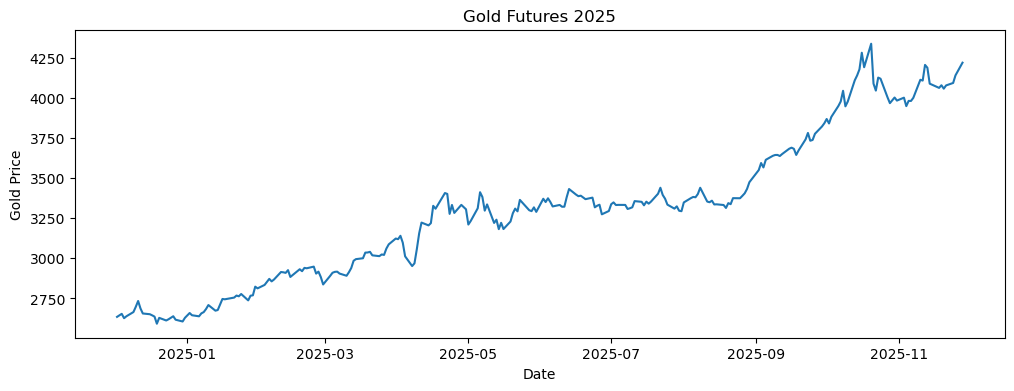

In [27]:
# Plot Gold_Price over time
plt.figure(figsize=(12,4))
plt.plot(df["Date"], df["Gold_Price"])
plt.title("Gold Futures 2025")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.show()

Gold futures prices rose from ~$2,650 (Dec 2024) to over $4,200 by late 2025, with a sharp surge after mid-year.

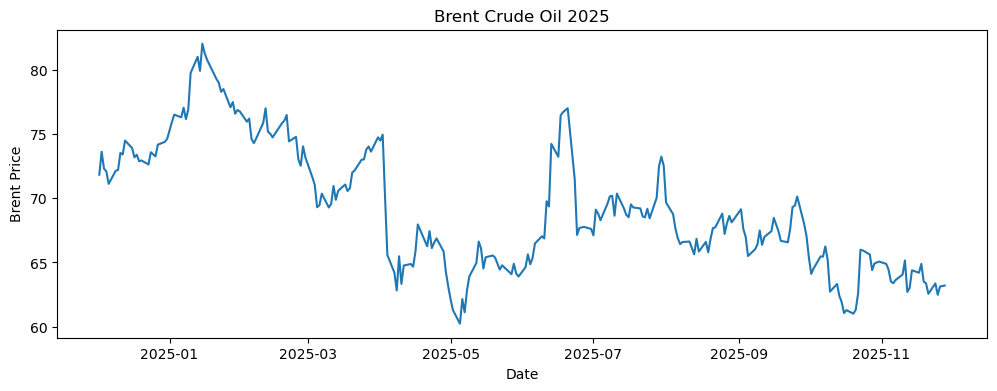

In [28]:
# Plot Brent_Price over time
plt.figure(figsize=(12,4))
plt.plot(df["Date"], df["Brent_Price"])
plt.title("Brent Crude Oil 2025")
plt.xlabel("Date")
plt.ylabel("Brent Price")
plt.show()

Brent oil prices remained highly volatile between $60–$85 with no clear trend, showing inconsistent behavior.

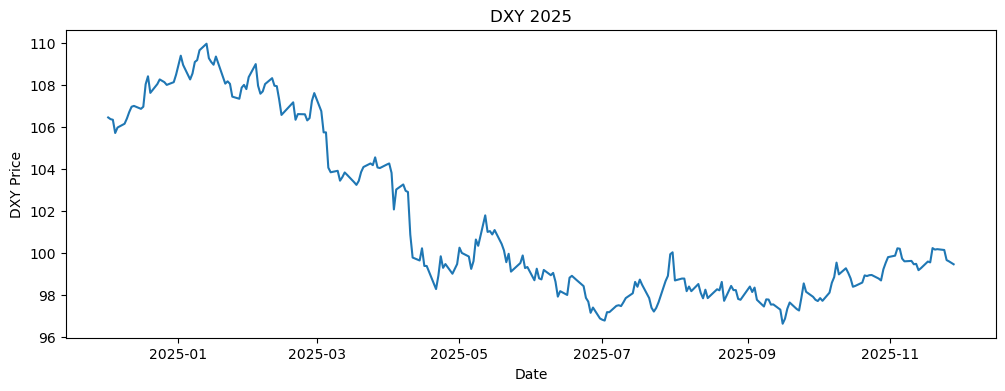

In [29]:
# Plot DXY_Price over time
plt.figure(figsize=(12,4))
plt.plot(df["Date"], df["DXY_Price"])
plt.title("DXY 2025")
plt.xlabel("Date")
plt.ylabel("DXY Price")
plt.show()


The US Dollar Index (DXY) declined overall from ~110 to below 98, reflecting persistent dollar weakness.

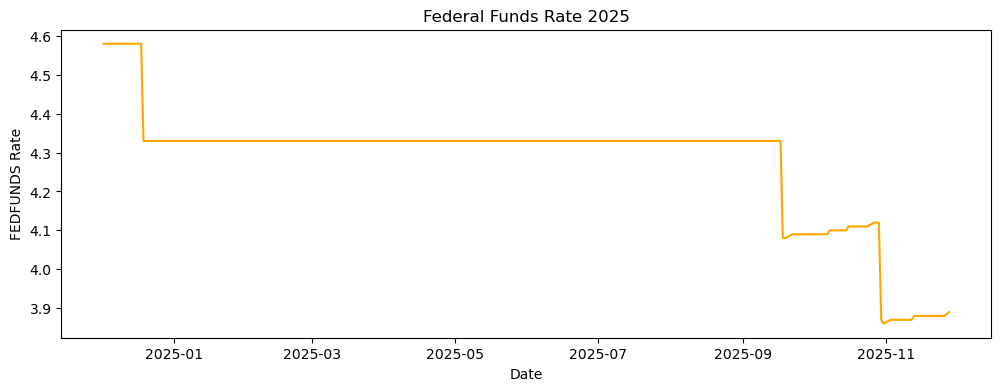

In [30]:
## Plot FEDFUNDS_Price over time
plt.figure(figsize=(12,4))
plt.plot(df["Date"], df["Fed_Rate"], color='orange')
plt.title("Federal Funds Rate 2025")
plt.xlabel("Date")
plt.ylabel("FEDFUNDS Rate")
plt.show()

The Federal Funds Rate in 2025 started near 4.6%, dropped quickly to around 4.3% early in the year, remained stable through mid-year, then declined sharply in the fall, ending near 3.9% by late 2025.

##### Distribution analysis
- Shows spread and skewness

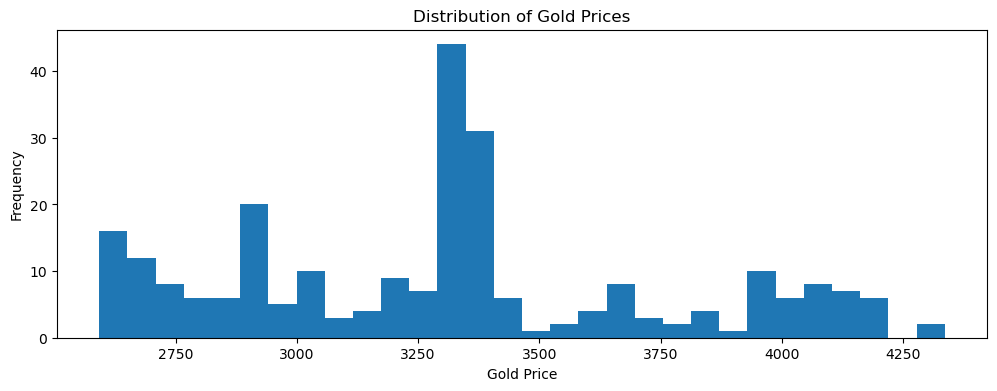

In [31]:
# Distribution of Gold Prices
plt.figure(figsize=(12,4))
plt.hist(df["Gold_Price"], bins=30)
plt.xlabel("Gold Price")
plt.ylabel("Frequency")
plt.title("Distribution of Gold Prices")
plt.show()

Gold Prices: Multimodal with a main peak at ~$3,250–$3,300, reflecting the upward price trend.

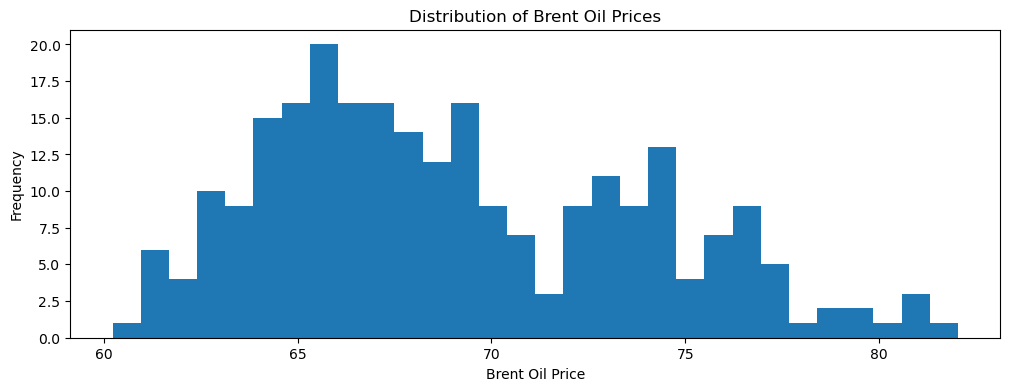

In [32]:
plt.figure(figsize=(12,4))
plt.hist(df["Brent_Price"], bins=30)
plt.xlabel("Brent Oil Price")
plt.ylabel("Frequency")
plt.title("Distribution of Brent Oil Prices")
plt.show()

Brent Crude Oil: Roughly normal distribution centered around $65–$70, with moderate volatility.

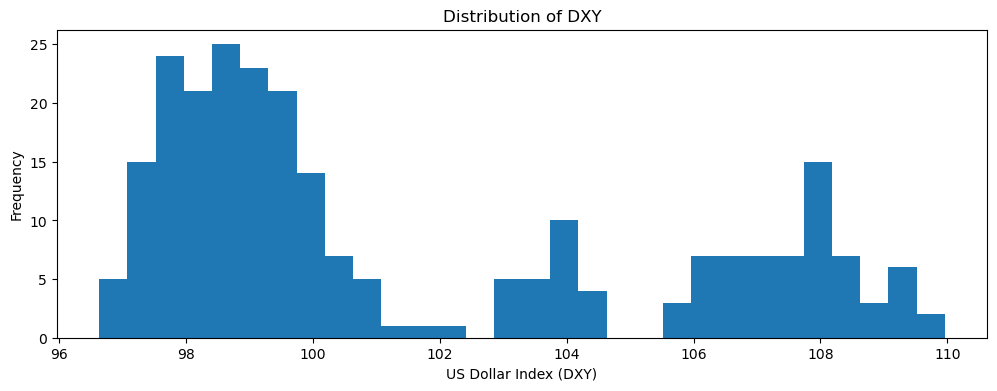

In [33]:
# Distribution of DXY
plt.figure(figsize=(12,4))
plt.hist(df["DXY_Price"], bins=30)
plt.xlabel("US Dollar Index (DXY)")
plt.ylabel("Frequency")
plt.title("Distribution of DXY")
plt.show()

DXY: Right-skewed, most frequent around 98–100, indicating overall dollar weakness.

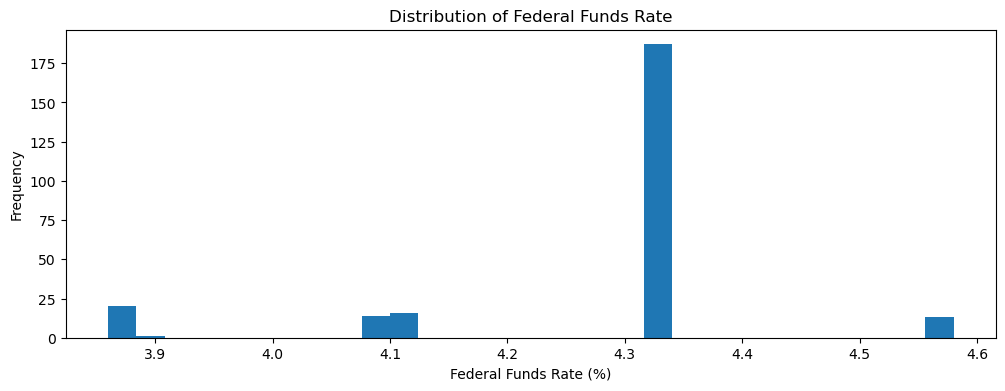

In [34]:
# Distribution of FED Funds Rate
plt.figure(figsize=(12,4))
plt.hist(df["Fed_Rate"], bins=30)
plt.xlabel("Federal Funds Rate (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Federal Funds Rate")
plt.show()

Federal Funds Rate stayed mostly at 4.33% for the longest time (over 160 days), with brief drops to 4.09%, and 3.88%, and short periods near 4.48%.

##### Correlation analysis
- Explores relationships

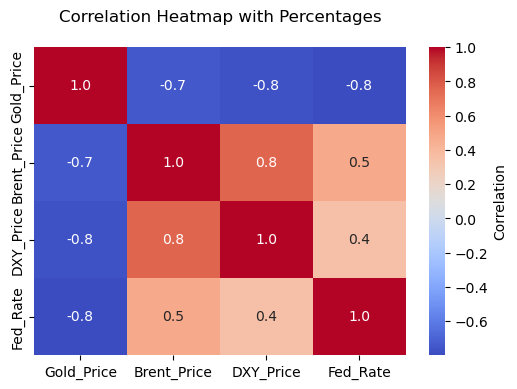

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

# Heatmap with annotations (showing percentages)
sns.heatmap(
    df[["Gold_Price", "Brent_Price", "DXY_Price", "Fed_Rate"]].corr(),
    annot=True,          # show values
    fmt=".1f",           # 1 decimal place
    cmap="coolwarm",     # color map
    cbar_kws={'label': 'Correlation'}  # colorbar label
)

plt.title("Correlation Heatmap with Percentages\n")
plt.show()


- Gold price is strongly negatively correlated with the Federal Funds Rate (-0.8), so lower rates support higher gold prices.

- Gold price is strongly negatively correlated with DXY (-0.8), meaning a weaker dollar boosts gold.

- Gold has a moderate negative correlation with Brent oil (-0.7).

- Brent oil price is positively correlated with DXY (0.8), showing they tend to rise together, and positively correlated with Federal Funds Rate (.5).

- Overall, the Fed rate and DXY are the main inverse drivers of gold price.


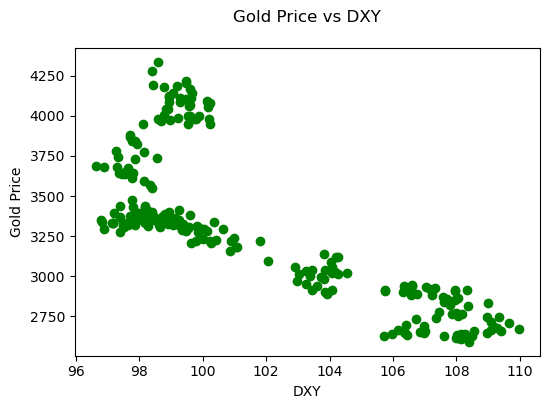

In [36]:
# Scatter plot: DXY vs Gold Price
plt.figure(figsize=(6,4))
plt.scatter(df["DXY_Price"], df["Gold_Price"], color='green')
plt.xlabel("DXY")
plt.ylabel("Gold Price")
plt.title("Gold Price vs DXY\n")
plt.show()

Gold price exhibits a strong inverse relationship with DXY, as higher gold prices cluster at lower DXY values (below 100).

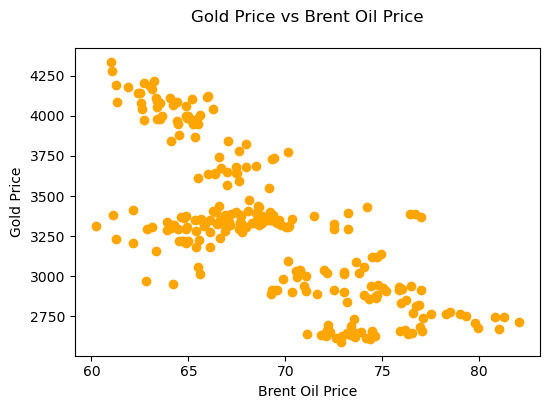

In [37]:
# Scatter plot: Brent Oil Price vs Gold Price
plt.figure(figsize=(6,4))
plt.scatter(df["Brent_Price"], df["Gold_Price"], color='orange')
plt.xlabel("Brent Oil Price")
plt.ylabel("Gold Price")
plt.title("Gold Price vs Brent Oil Price\n")
plt.show()

Gold and Brent oil show a scattered pattern with a slight downward trend, indicating a moderate negative relationship.

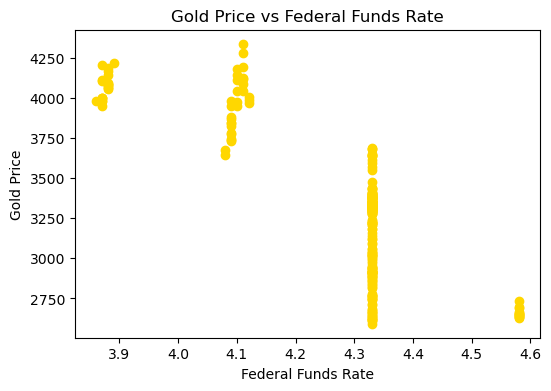

In [38]:
# Scatter plot: Federal Funds Rate vs Gold Price
plt.figure(figsize=(6,4))
plt.scatter(df["Fed_Rate"], df["Gold_Price"], color='gold')
plt.xlabel("Federal Funds Rate")
plt.ylabel("Gold Price")
plt.title("Gold Price vs Federal Funds Rate")
plt.show()

Gold prices are distinctly clustered by discrete Fed rate levels, with higher gold prices corresponding to lower rates (strong inverse relationship).

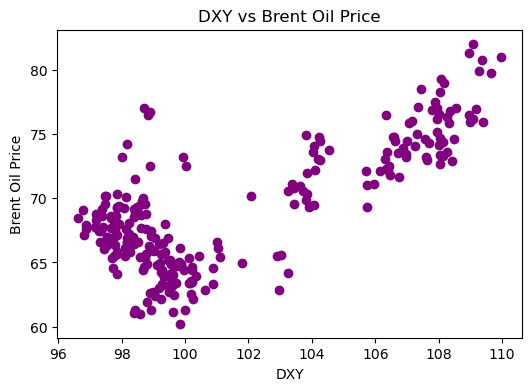

In [39]:
# Scatter plot: DXY vs Brent Oil Price
plt.figure(figsize=(6,4))
plt.scatter(df["DXY_Price"], df["Brent_Price"], color='purple')
plt.xlabel("DXY")
plt.ylabel("Brent Oil Price")
plt.title("DXY vs Brent Oil Price")
plt.show()

A clear positive correlation is visible, as higher DXY values align with higher Brent oil prices around $75–$80.

##### Outlier Detection

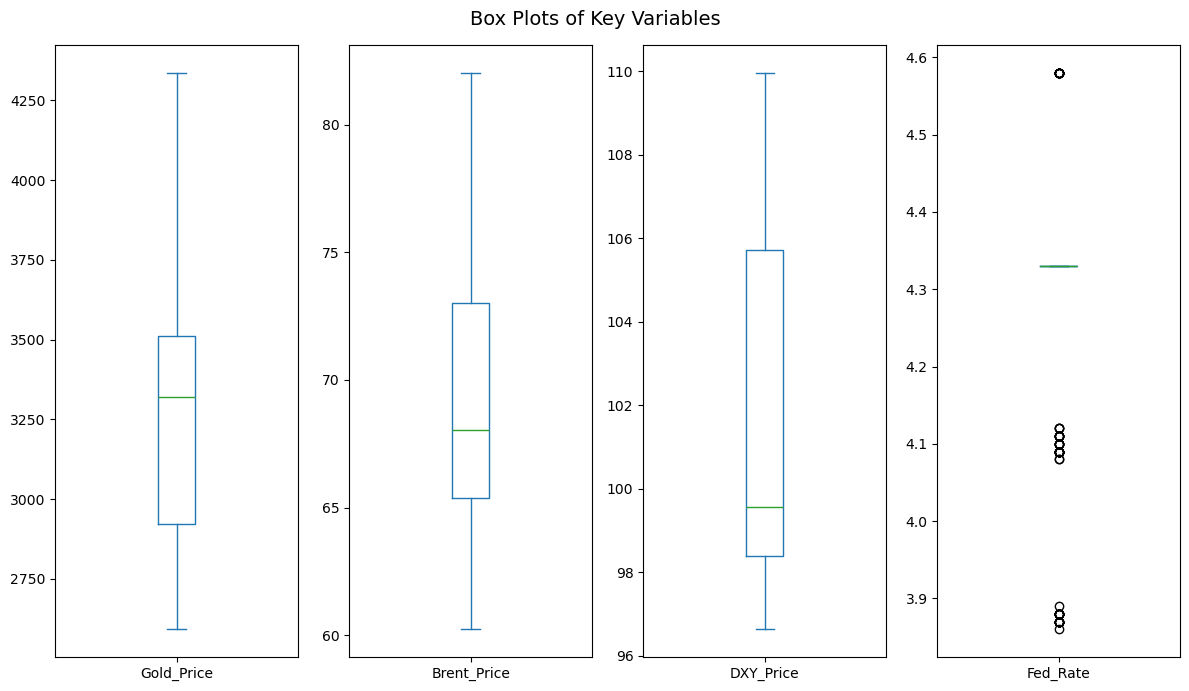

In [40]:
key_columns = ['Gold_Price', 'Brent_Price', 'DXY_Price', 'Fed_Rate']

# Create box plots (subplots) only for the selected columns
df[key_columns].plot(kind='box', subplots=True, layout=(1, 4), figsize=(12, 7))

plt.suptitle('Box Plots of Key Variables', fontsize=14)
plt.tight_layout()
plt.show()

No major outliers in Gold, Brent, or DXY prices. Only in the Federal Funds Rate the boxplot shows outliers, most values are clustered around the median, with a few unusually high and low outliers.

## Preprocessing


### Train-test split
- **Training set:** first 80% of the data (earlier dates)  
- **Test set:** last 20% of the data (later dates)

In [41]:
from sklearn.preprocessing import StandardScaler

# Time series split: 80% train, 20% test
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (200, 9)
Test shape: (51, 9)


### Feature scaling
The numeric features (`Gold_Price`, `High`, `Low`, `Open`, `Volume`, `Brent_Price`, `DXY_Price`, `FEDFUNDS_Price`) are on very different scales. To standardize them:  
- **StandardScaler** is used to scale features to have **mean = 0** and **standard deviation = 1**.  
- The scaler is **fitted only on the training data**, so the model learns parameters from past data only.  
- The same scaler is then used to **transform the test data**, ensuring consistent scaling and avoiding data leakage.  


#### Feature Scaling for SGD and SVR

Feature scaling was applied specifically for **SGD** and **Support Vector Regression (SVR)** models.

**Why scaling is necessary:**
- Both SGD and SVR rely on distance-based optimization methods.
- Features with larger numerical ranges can dominate the learning process if scaling is not applied.
- Scaling ensures that all features contribute equally to the model.

Standardization was used to transform features to zero mean and unit variance.


In [42]:
from sklearn.preprocessing import StandardScaler

# Input features ONLY
feature_cols = ["High", "Low", "Open", "Volume",
                "Brent_Price", "DXY_Price", "Fed_Rate"]

target_col = "Gold_Price"

# Time-based split already done
scaler = StandardScaler()

# Scale FEATURES only
X_train_scaled = scaler.fit_transform(train_df[feature_cols])
X_test_scaled = scaler.transform(test_df[feature_cols])

# Target remains UNCHANGED
y_train = train_df[target_col]
y_test = test_df[target_col]


## Training

In [43]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)


### Models Used
To evaluate different modeling approaches, three regression models are trained:

- **Linear Regression:**  
- **Random Forest Regressor:**  

- **Gradient Boosting Regressor:**
- **Support Vector Regression (SVR)**
- **Stochastic Gradient Descent (SGD)**

#### Linear Regression
- Assumes a linear relationship between features and Gold price.

- Simple, interpretable, and performs well on small datasets.

In [44]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred_lr = lr_model.predict(X_test_scaled)


#### Random Forest Regressor
- Ensemble of trees capturing non-linear relationships and feature interactions.

- Robust and provides feature importance.


In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_param_grid,
    cv=tscv,   # ✅ time-aware CV
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

# Raw (unscaled) features for tree models
X_train_raw = train_df[feature_cols]
X_test_raw = test_df[feature_cols]

# ----- Random Forest -----
rf_grid.fit(X_train_raw, y_train)
rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_test_raw)

print("Best RF params:", rf_grid.best_params_)


Best RF params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


#### Gradient Boosting Regressor (XGBoost)
- Builds trees one after another, trying to fix the mistakes of the previous trees.

- Can find small patterns that Random Forest might miss

In [46]:
from sklearn.ensemble import GradientBoostingRegressor

gb_param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [2, 3]
}

gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_param_grid,
    cv=tscv,   # ✅ time-aware CV
    scoring="neg_mean_absolute_error"
)

# Raw (unscaled) features for tree models
X_train_raw = train_df[feature_cols]
X_test_raw = test_df[feature_cols]


gb_grid.fit(X_train_raw, y_train)
gb_best = gb_grid.best_estimator_
y_pred_gb = gb_best.predict(X_test_raw)

print("Best GB params:", gb_grid.best_params_)


Best GB params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


#### Support Vector Regression (SVR)
- Kernel-based regression capturing non-linear relationships.

- Works well on small datasets; sensitive to feature scaling.

In [47]:
from sklearn.svm import SVR

svr_param_grid = {
    "C": [10, 100, 500],
    "gamma": [0.01, 0.1, 0.5],
    "epsilon": [0.01, 0.1]
}

svr_grid = GridSearchCV(
    SVR(kernel="rbf"),
    svr_param_grid,
    cv=tscv,   # ✅ time-aware CV
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

svr_grid.fit(X_train_scaled, y_train)

svr_best = svr_grid.best_estimator_
y_pred_svr = svr_best.predict(X_test_scaled)

print("Best SVR params:", svr_grid.best_params_)


Best SVR params: {'C': 500, 'epsilon': 0.1, 'gamma': 0.01}


#### Stochastic Gradient Descent (SGD) Model


In [48]:
from sklearn.linear_model import SGDRegressor

sgd_param_grid = {
    "alpha": [1e-6, 1e-5, 1e-4],
    "learning_rate": ["constant", "optimal", "invscaling"],
    "eta0": [0.001, 0.01],
     "max_iter": [1000,3000, 5000],
    "penalty": ["l2", "l1", "elasticnet"]
}

sgd_grid = GridSearchCV(
    SGDRegressor(random_state=42),
    sgd_param_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

sgd_grid.fit(X_train_scaled, y_train)

sgd_best = sgd_grid.best_estimator_
y_pred_sgd = sgd_best.predict(X_test_scaled)

print("Best SGD params:", sgd_grid.best_params_)


Best SGD params: {'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'constant', 'max_iter': 1000, 'penalty': 'l2'}


The **SGDRegressor** model was added to the pipeline because it supports **online learning**.

**Why SGD was included:**
- SGD can be updated incrementally with new data using `partial_fit`, making it suitable for **real-time or streaming data** scenarios.
- It is computationally efficient and scalable for large datasets.
- This makes SGD a practical choice for future extensions of the project.

SGD was not only evaluated for accuracy but also for its adaptability in dynamic financial environments.


##### Linear Regression as a Baseline Model

Linear Regression was retained as a **baseline model** for comparison.

**Why Linear Regression was kept:**
- It provides a simple and interpretable reference point.
- Its performance was found to be **very close to more complex models**, indicating strong linear relationships in the data.
- Using a simple model helps validate whether additional model complexity is truly necessary.

The closeness of its results to advanced models confirms that Linear Regression is a strong and reliable baseline.


## Cross-Validation (TimeSeriesSplit)

To evaluate how well each model generalizes over different **time periods** (without shuffling), we apply **TimeSeriesSplit (5 folds)** on the training portion only.

We report:
- **MAE** (lower is better)
- **MAPE** (percentage error, lower is better)

> Note: For models that need feature scaling (Linear Regression, SVR, SGD), scaling is done **inside a Pipeline** so it is fit only on each training fold (no leakage).

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_absolute_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np

# Use the SAME time-aware CV splitter already defined above
# tscv = TimeSeriesSplit(n_splits=5)


X_train_cv = train_df[feature_cols]
y_train_cv = y_train

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

def cv_summary(name, estimator, X, y):
    scores = cross_validate(
        estimator,
        X, y,
        cv=tscv,
        scoring={"MAE": mae_scorer, "MAPE": mape_scorer},
        n_jobs=-1
    )

    mae_mean = -np.mean(scores["test_MAE"])
    mae_std  =  np.std(scores["test_MAE"])
    mape_mean = -np.mean(scores["test_MAPE"]) * 100
    mape_std  =  np.std(scores["test_MAPE"]) * 100
    return {
        "Model": name,
        "CV MAE (mean)": mae_mean,
        "CV MAE (std)": abs(mae_std),
        "CV MAPE% (mean)": mape_mean,
        "CV MAPE% (std)": abs(mape_std)
    }

results = []

# 1) Linear Regression
lr_cv = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])
results.append(cv_summary("Linear Regression", lr_cv, X_train_cv, y_train_cv))

# 2) Random Forest
results.append(cv_summary("Random Forest ", rf_best, X_train_cv, y_train_cv))

# 3) Gradient Boosting
results.append(cv_summary("Gradient Boosting ", gb_best, X_train_cv, y_train_cv))

# 4) SVR
svr_cv = Pipeline([
    ("scaler", StandardScaler()),
    ("model", svr_best)
])
results.append(cv_summary("SVR ", svr_cv, X_train_cv, y_train_cv))

# 5) SGD Regressor
sgd_cv = Pipeline([
    ("scaler", StandardScaler()),
    ("model", sgd_best)
])
results.append(cv_summary("SGD Regressor ", sgd_cv, X_train_cv, y_train_cv))

cv_results_df = pd.DataFrame(results).sort_values("CV MAE (mean)")
cv_results_df

,Model,CV MAE (mean),CV MAE (std),CV MAPE% (mean),CV MAPE% (std)
0,Linear Regression,10.382832,3.177544,0.330236,0.121241
4,SGD Regressor,16.355201,2.847424,0.514526,0.122988
3,SVR,66.070859,49.846974,2.064996,1.586072
1,Random Forest,86.202776,66.206550,2.694860,2.115605
2,Gradient Boosting,86.477859,64.621343,2.696668,2.054576


## Model Evaluation Using MAE and MAPE

We evaluated model performance using **Mean Absolute Error (MAE)** and **Mean Absolute Percentage Error (MAPE)**.

#### Mean Absolute Error (MAE)
MAE measures the average absolute difference between predicted and actual values.

**Why MAE was chosen:**
- It is expressed in the **same units as the target variable** (gold price), making it easy to interpret.
- It provides a clear indication of the average prediction error magnitude.
- It is **less sensitive to extreme outliers** than squared-error metrics, which is important for volatile financial data.

#### Mean Absolute Percentage Error (MAPE)
MAPE measures the average error as a **percentage of the actual values**.

**Why MAPE was added:**
- It provides a **relative error measure**, which helps assess model performance independent of price scale.
- Percentage-based error is more intuitive for comparing models across different time periods.
- It allows us to understand how large the prediction error is **relative to the true gold price**, which is especially useful in financial analysis.

Using both MAE and MAPE provides a more comprehensive evaluation by combining **absolute error interpretation** with **relative performance comparison**.


In [50]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Compute MAE and MAPE for each model

# Linear Regression
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)
print(f"Linear Regression - MAE: {mae_lr:.2f} | MAPE: {mape_lr*100:.2f}%")

# Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
print(f"Random Forest - MAE: {mae_rf:.2f} | MAPE: {mape_rf*100:.2f}%")

# Gradient Boosting
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mape_gb = mean_absolute_percentage_error(y_test, y_pred_gb)
print(f"Gradient Boosting - MAE: {mae_gb:.2f} | MAPE: {mape_gb*100:.2f}%")

# Support Vector Regression
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mape_svr = mean_absolute_percentage_error(y_test, y_pred_svr)
print(f"SVR - MAE: {mae_svr:.2f} | MAPE: {mape_svr*100:.2f}%")

# SGD Regressor
mae_sgd = mean_absolute_error(y_test, y_pred_sgd)
mape_sgd = mean_absolute_percentage_error(y_test, y_pred_sgd)
print(f"SGD Regressor - MAE: {mae_sgd:.2f} | MAPE: {mape_sgd*100:.2f}%")


Linear Regression - MAE: 12.93 | MAPE: 0.32%
Random Forest - MAE: 346.37 | MAPE: 8.50%
Gradient Boosting - MAE: 335.70 | MAPE: 8.24%
SVR - MAE: 343.36 | MAPE: 8.45%
SGD Regressor - MAE: 18.62 | MAPE: 0.46%


Although Linear Regression achieved the lowest error among the evaluated models, Stochastic Gradient Descent (SGD) regression was selected as the final model due to its suitability for online and incremental learning.

 SGD allows the model to be continuously updated as new data becomes available without the need for full retraining, which is particularly important in time-dependent financial data where patterns may evolve over time.

  Moreover, the performance of SGD was very close to that of Linear Regression, indicating that the slight increase in error is an acceptable trade-off for the added flexibility, scalability, and adaptability of online learning.
  
   This makes SGD a more practical and robust choice for real-world deployment despite Linear Regression achieving marginally lower static evaluation error.

## Check for Overfitting (SGD Regressor)
- To ensure the SGD Regressor generalizes well to unseen data


**Train vs Test Performance**
- We compute the MAE on both the training set and the unseen test set.

In [51]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np

# Predictions using SCALED features
y_train_pred_sgd = sgd_best.predict(X_train_scaled)
y_test_pred_sgd = sgd_best.predict(X_test_scaled)

# Train vs Test MAE
mae_train_sgd = mean_absolute_error(y_train, y_train_pred_sgd)
mae_test_sgd = mean_absolute_error(y_test, y_test_pred_sgd)

print("MAE Train (SGD):", mae_train_sgd)
print("MAE Test (SGD):", mae_test_sgd)


MAE Train (SGD): 9.751403046231585
MAE Test (SGD): 18.621592244598748


The small difference between train and test MAE shows that the model generalizes well and is not overfitting.

## Create a Pipeline

### Updated Modeling Pipeline

The modeling pipeline was updated to properly integrate **SGD** alongside other models.

Key updates:
- Feature scaling was applied **before training SGD and SVR**.
- Linear Regression was trained on unscaled data as it is not sensitive to feature magnitudes.
- Each model was evaluated under conditions that best match its mathematical assumptions.

This ensures a fair comparison between models and improves overall reliability of results.


In [52]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib

# RAW features only
X_train_raw = train_df[feature_cols]
y_train = train_df[target_col]

sgd_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("sgd", sgd_best)
])

sgd_pipeline.fit(X_train_raw, y_train)

joblib.dump(sgd_pipeline, "sgd_pipeline.pkl")
loaded_pipeline = joblib.load("sgd_pipeline.pkl")

loaded_pipeline.feature_names_in_
print("Pipeline saved as 'sgd_pipeline.pkl'")

Pipeline saved as 'sgd_pipeline.pkl'


## Summary of Model Design Decisions

- Daily EFFR was used to better capture short-term market dynamics.
- Hyperparameter tuning improved model generalization.
- SGD was added for its online learning capability.
- Linear Regression served as a strong and interpretable baseline.
- Feature scaling was applied where mathematically required.
- MAE was selected as a robust and interpretable evaluation metric.

These decisions collectively enhanced the accuracy, flexibility, and reliability of the predictive system.
